# Electron Photon tagging

This is a first test to implement a QAE and compare it to a classical AE.  
The task is to identify Electrons and Photons from em-calorimeter images.

In [21]:
import h5py

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit
import tensorflow as tf
import tensorflow_quantum as tfq
from hep_VQAE import data_preprocessing as dp


import warnings
warnings.filterwarnings('ignore')

2022-06-29 18:21:48.751267: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 18:21:48.751287: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-29 18:21:50.008590: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-29 18:21:50.008627: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-29 18:21:50.008643: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tomskopfbahnhof): /proc/driver/nvidia/version does not exist
2022-06-29 18:21:50.008857: I tensorflow/core/platform/cpu_fe

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train/255.0, x_test/255.0
print("x_train: ", x_train.shape)
print("x_test: ", x_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

x_train:  (60000, 28, 28)
x_test:  (10000, 28, 28)
y_train:  (60000,)
y_test:  (10000,)


Average images:

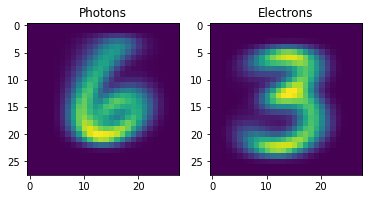

In [3]:
fig, axs = plt.subplots(1,2)

axs[0].imshow(np.average(x_train[y_train==6],0))
axs[0].title.set_text('Photons')

axs[1].imshow(np.average(x_train[y_train==3],0))
axs[1].title.set_text('Electrons')

Train on 6s and 3s

In [4]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


# Dimensionality reduction

To use the QAE we need to reduce the dimension as only a couple of qbits are available.
The easiest way is a simple PCA.

In [5]:
DOWNSCALE = 2
DATA_DIMENSION = DOWNSCALE*DOWNSCALE
LATENT_BITS = 2

x_train, x_test = dp.PCA_reduce(x_train, DATA_DIMENSION, val_data=x_test)
print(np.max(x_train))
print(np.min(x_train))
print(x_train.shape)
print(x_test.shape)

1.0
0.0
(12049, 4)
(1968, 4)


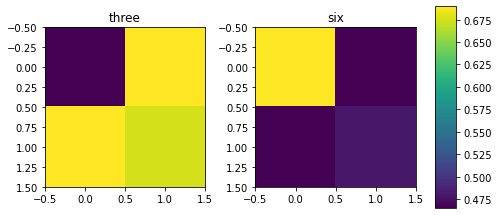

In [6]:
fig, axs = plt.subplots(1,2)
img0 = axs[0].imshow(np.average(x_train[y_train==True],0).reshape(DOWNSCALE,DOWNSCALE))
axs[0].title.set_text('three')

img1 = axs[1].imshow(np.average(x_train[y_train==False],0).reshape(DOWNSCALE,DOWNSCALE))
axs[1].title.set_text('six')

cbar_ax = fig.add_axes([1, 0.15, 0.05, 0.7])
fig.colorbar(img1, orientation='vertical', cax=cbar_ax)

fig.tight_layout()

After the PCA it looks like Photons and Electrons should still seperate quite well.

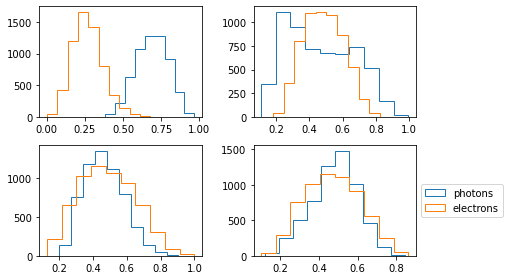

In [7]:
fig, axs = plt.subplots(DOWNSCALE,DOWNSCALE)
for i in range(0,DATA_DIMENSION):
    axs[i//DOWNSCALE,i%DOWNSCALE].hist(x_train[y_train==0][:,i], label="photons", histtype='step')
    axs[i//DOWNSCALE,i%DOWNSCALE].hist(x_train[y_train==1][:,i], label="electrons", histtype='step')
fig.tight_layout()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

I want only want to train the AE on Photons and later try to separate them from the electrons without training on electron data.
Therefore I only include Photons in x_train.


In [8]:
x_train_threes = x_train[y_train==True]
x_train = x_train[y_train==False]

x_test_threes = x_test[y_test==True]
x_test = x_test[y_test==False]

Input states need to be prepared accordingly.
The position of the reference bits depends on the number of latent bits.

In [10]:
x_train_circuit = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_train]
x_test_circuit = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_test]

x_train_circuit_threes = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_train_threes]
x_test_circuit_threes = [dp.input_states(x,DATA_DIMENSION,LATENT_BITS) for x in x_test_threes]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


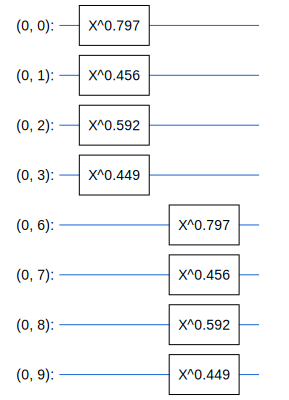

In [11]:
SVGCircuit(x_train_circuit[0])

In [12]:
x_train_tf = tfq.convert_to_tensor(x_train_circuit)
x_test_tf = tfq.convert_to_tensor(x_test_circuit)

x_train_tf_threes = tfq.convert_to_tensor(x_train_circuit_threes)
x_test_tf_threes = tfq.convert_to_tensor(x_test_circuit_threes)

Use QAE model, in this case with 7 layers

In [13]:
from hep_VQAE import QAE as qae

model = qae.QAE_model(4,LATENT_BITS,7)

Train with mse

In [14]:
model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.1))

In [15]:
y_train_ones = np.ones(shape=len(x_train_tf))
y_test_ones = np.ones(shape=len(x_test_tf))

y_train_ones_threes = np.ones(shape=len(x_train_tf_threes))
y_test_ones_threes = np.ones(shape=len(x_test_tf_threes))

In [16]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train_tf, y_train_ones, epochs=50, batch_size=64, validation_data=(x_test_tf, y_test_ones), callbacks=[es])

Epoch 1/50
93/93 [==============================] - 22s 234ms/step - loss: 0.1267 - val_loss: 0.0458
Epoch 2/50
93/93 [==============================] - 21s 230ms/step - loss: 0.0355 - val_loss: 0.0272
Epoch 3/50
93/93 [==============================] - 21s 228ms/step - loss: 0.0218 - val_loss: 0.0231
Epoch 4/50
93/93 [==============================] - 22s 233ms/step - loss: 0.0216 - val_loss: 0.0229
Epoch 5/50
93/93 [==============================] - 21s 229ms/step - loss: 0.0221 - val_loss: 0.0231
Epoch 6/50
93/93 [==============================] - 22s 236ms/step - loss: 0.0214 - val_loss: 0.0238
Epoch 7/50
93/93 [==============================] - 21s 230ms/step - loss: 0.0218 - val_loss: 0.0228
Epoch 8/50
93/93 [==============================] - 21s 229ms/step - loss: 0.0213 - val_loss: 0.0242
Epoch 9/50
93/93 [==============================] - 21s 222ms/step - loss: 0.0213 - val_loss: 0.0254
Epoch 10/50
93/93 [==============================] - 21s 231ms/step - loss: 0.0214 - val_lo

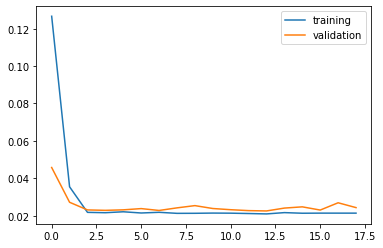

In [17]:
plt.plot(history.history['loss'], label="training")
plt.plot(history.history['val_loss'], label="validation")
#plt.yscale('log')
plt.legend()

In [18]:
pred_six = model.predict(x_test_tf)
print("Median six reconstruciton fidelities: ",np.median(pred_six))

pred_three = model.predict(x_test_tf_threes)
print("Median three reconstruciton fidelities: ", np.median(pred_three))

Median six reconstruciton fidelities:  0.89336836
Median three reconstruciton fidelities:  0.35121083


(array([ 69., 185., 243., 232., 145.,  70.,  43.,  15.,   7.,   1.]),
 array([0.07214803, 0.16434267, 0.25653732, 0.34873196, 0.44092658,
        0.5331212 , 0.62531585, 0.7175105 , 0.80970514, 0.9018998 ,
        0.99409443], dtype=float32),
 [<matplotlib.patches.Polygon at 0x7f05e9a1a640>])

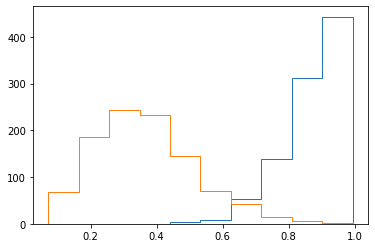

In [19]:
bins = np.histogram(np.hstack((pred_six.reshape((pred_six.shape[0],)), pred_three.reshape((pred_three.shape[0],)))), bins=10)[1]
plt.hist(pred_six, histtype='step', label="sixes",bins=bins)
plt.hist(pred_three, histtype='step', label="threes",bins=bins)

0.9644308943089431


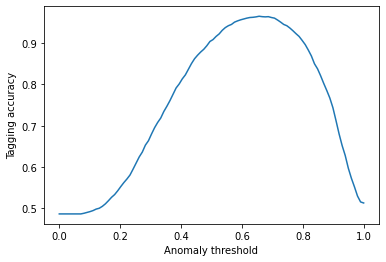

In [20]:
def acc_for_threshold(T):
    # sixes that are predicted six
    num_six_right = np.sum(pred_six > T)
    # threes that are predicted three
    num_three_right = np.sum(pred_three < T)
    acc = (num_six_right + num_three_right)/(len(pred_six) + len(pred_three))
    return acc

Ts = np.linspace(0,1,100)
accs = []
for i in Ts:
    accs.append(acc_for_threshold(i))
print(max(accs))
plt.ylabel("Tagging accuracy")
plt.xlabel("Anomaly threshold")
plt.plot(Ts, accs)  